## Note:
The `pymatgen` defect compatibility analysis can be too strict when locating the defect site, if the defect has moved a little during relaxation. This can then lead to the following error with the `SingleDefectParser.run_compatibility()` method:
```python
(Traceback)...

~/anaconda3/lib/python3.9/site-packages/pymatgen/analysis/defects/defect_compatibility.py in check_final_relaxed_structure_delocalized(self, defect_entry)
    605 
    606         if defindex is None and not isinstance(defect_entry.defect, Vacancy):
--> 607             raise ValueError("fractional coordinate for defect could not be " "identified in initial_defect_structure")
    608 
    609         distdata.sort()

ValueError: fractional coordinate for defect could not be identified in initial_defect_structure
```

Unfortunately, `pymatgen` does not offer any optional arguments to loosen the tolerance of these functions, so the easiest way to avoid this (without rewriting the entire `pymatgen` defects corrections code) is to run:   
On the command line:
```bash
sed -i ".bak" "s/if site.distance_and_image_from_frac_coords(def_frac_coords)\[0\] < 0.01/if site.distance_and_image_from_frac_coords(def_frac_coords)\[0\] < 2.5/" ~/anaconda3/lib/python3.9/site-packages/pymatgen/analysis/defects/defect_compatibility.py
```
or in the `Jupyter` notebook (adding "!" to the start of the cell code runs it as a `bash` command, rather than python:
```bash
!sed -i ".bak" "s/if site.distance_and_image_from_frac_coords(def_frac_coords)\[0\] < 0.01/if site.distance_and_image_from_frac_coords(def_frac_coords)\[0\] < 2.5/" ~/anaconda3/lib/python3.9/site-packages/pymatgen/analysis/defects/defect_compatibility.py
```

You may have to modify the `~/anaconda3/lib/python3.9/site-packages/pymatgen` path to match that given in the `ValueError` message, depending on your installation (e.g. may have to change `anaconda3` to `miniconda3`, or `python3.9` to `python3.x` if you have a different version). If you are running a different version of `bash` (this works for MacOS at least), you may have to remove the `"bak"` part of this command.

## Some Defect Calculation results for $V_{Cd}$

In this example, `vac_1_Cd_0` wasn't generated with `doped`, and so the defect site is not the `doped`-generated one (0,0,0), but (0.5, 0.5, 0.5). Often `doped` can parse the defect fine, automatically determining the defect type and site from the relaxed structure.

However, sometimes it needs a little help (if the defect undergoes significant relaxation for example). This is why we have the `vasp_input.prepare_vasp_defect_dict()` function, to generate `transformation.json` files so that `doped` always knows what type of defect is present. In this case, we don't have (initially) have a `transformation.json` file because we didn't generate the defect with `doped`, but what we _can_ do is get a `transformation.json` file from a different defect (that we have generated with `doped`), and modify to give the correct info for `vac_1_Cd_0` (i.e. defect charge, initial site etc.). That's what we've done here.

In [1]:
from doped import dope_stuff

In [2]:
from doped.pycdt.utils import parse_calculations
import numpy as np
import os

In [5]:
bulk_file_path = "Bulk_Supercell/vasp_ncl"
dielectric = np.array([[9.13, 0, 0],[0., 9.13, 0],[0, 0, 9.13]])
parsed_vac_Cd_dict = {}

for i in os.listdir(): # this loops through the folders in the current directory, and parses those that have "vac_1_Cd" in their name
    if 'vac_1_Cd' in i and len(i)<12:
        print(i)
        defect_file_path = f"{i}/vasp_ncl" # assumes your final calculation results are in subfolders called vasp_ncl. E.g. vac_1_Cd_0/vasp_ncl/ etc
        defect_charge = int(i[-2:].replace("_",""))

        # Note that we've added the optional argument initial_defect_structure to 
        # SingleDefectParser.from_paths() in case PyCDT has trouble finding defect site
        # i.e. use the unrelaxed, PyCDT generated POSCAR in the local defect folder
        sdp = parse_calculations.SingleDefectParser.from_paths(defect_file_path, bulk_file_path,
                                            dielectric, defect_charge,
                                            initial_defect_structure=f"{i}/vasp_gam/POSCAR") # Best to use your actual un-relaxed starting defect structure here, if possible
        print(f"Uncorrected energy: {sdp.defect_entry.uncorrected_energy:.3f} eV")
        bo = sdp.freysoldt_loader()
        sdp.get_stdrd_metadata()

# We've also added actual_bulk optional argument to pycdt.utils.parse_calculations.SingleDefectParser.get_bulk_gap_data(), in case we're
# looking at defect complexes (so the SingleDefectParser 'bulk' is actually the original point defect, with the wrong pmg-computed gap)
        sdp.get_bulk_gap_data(no_MP=True, actual_bulk_path=None)
        sdp.run_compatibility()
        print("Defect entry corrections:")
        print(sdp.defect_entry.corrections)
        print(f"Corrected energy: {sdp.defect_entry.energy:.3f} eV", "\n")
        parsed_vac_Cd_dict[i] = sdp.defect_entry # Keep dictionary of parsed defect entries
# Note that the PyCDT/pymatgen kumagai correction scheme uses the atomic core potentials from the OUTCAR

vac_1_Cd_-2
No transformation file exists at vac_1_Cd_-2/vasp_ncl/transformation.json or vac_1_Cd_-2/transformation.json.
Calculating defect index manually (proceed with caution)
Uncorrected energy: 7.661 eV
Manually fed mpid = None
This may not be appropriate if the VBM/CBM occur at reciprocal points not included in the bulk calculation.
Defect entry corrections:
{'charge_correction': 0.7376460317828045, 'bandfilling_correction': -0.0, 'bandedgeshifting_correction': 0.0}
Corrected energy: 8.398 eV 

vac_1_Cd_0
Uncorrected energy: 4.166 eV
Manually fed mpid = None
This may not be appropriate if the VBM/CBM occur at reciprocal points not included in the bulk calculation.
Defect entry corrections:
{'bandfilling_correction': -0.0, 'bandedgeshifting_correction': 0.0}
Corrected energy: 4.166 eV 

vac_1_Cd_-1
Uncorrected energy: 6.130 eV
Manually fed mpid = None
This may not be appropriate if the VBM/CBM occur at reciprocal points not included in the bulk calculation.
Defect entry correction

Note that you could also use something like:
```python
for i in ["vac_1_Cd_-2", "vac_1_Cd_-1", "vac_1_Cd_0"]:
    print("\n",i)
    defect_file_path = f"{i}/vasp_ncl" # assumes your final calculation results are in subfolders called vasp_ncl. E.g. vac_1_Cd_0/vasp_ncl/ etc
    ...
```
to loop over your calculation directories, or any other way you want.

In [ ]:
bulk_file_path = "Bulk_Supercell/vasp_ncl"
dielectric = np.array([[9.13, 0, 0],[0., 9.13, 0],[0, 0, 9.13]])
parsed_vac_Cd_dict = {}

for i in os.listdir():
    if 'vac_1_Cd_1' in i:
        print(i)
        defect_file_path = f"{i}/vasp_ncl"
        defect_charge = int(i[-2:].replace("_",""))
        sdp = parse_calculations.SingleDefectParser.from_paths(defect_file_path, bulk_file_path,
                                            dielectric, defect_charge)
        print(f"Uncorrected energy: {sdp.defect_entry.uncorrected_energy:.3f} eV")
        bo = sdp.freysoldt_loader()
        sdp.get_stdrd_metadata()
        sdp.get_bulk_gap_data(no_MP=True, actual_bulk_path=None)
        sdp.run_compatibility()
        print("Defect entry corrections:")
        print(sdp.defect_entry.corrections)
        print(f"Corrected energy: {sdp.defect_entry.energy:.3f} eV", "\n")
        parsed_vac_Cd_dict[i] = sdp.defect_entry

In [346]:
parsed_vac_Cd_dict['vac_1_Cd_0'].site

PeriodicSite: Cd (6.5434, 6.5434, 6.5434) [0.5000, 0.5000, 0.5000]

**Verifying unstable $T_d$ $V_{Cd}^{-1}$:**

In [ ]:
from doped.pycdt.utils import parse_calculations
import numpy as np

In [17]:
bulk_file_path = "Bulk_Supercell/vasp_ncl"
dielectric = np.array([[9.13, 0, 0],[0., 9.13, 0],[0, 0, 9.13]])
vac_1_Cd_vgam_dict = {}

for i in os.listdir():
    if 'vac_1_Cd_-1' in i:
        print(i)
        defect_file_path = f"{i}/vasp_gam"
        defect_charge = int(i[-2:].replace("_",""))
        sdp = parse_calculations.SingleDefectParser.from_paths(defect_file_path, bulk_file_path,
                                            dielectric, defect_charge,
                                            initial_defect_structure=f"{i}/vasp_gam/POSCAR") # Best to use your actual un-relaxed starting defect structure here, if possible
        print(f"Uncorrected energy: {sdp.defect_entry.uncorrected_energy:.3f} eV")
        bo = sdp.freysoldt_loader()
        sdp.get_stdrd_metadata()
        sdp.get_bulk_gap_data(no_MP=True, actual_bulk_path=None)
        sdp.run_compatibility()
        vac_1_Cd_vgam_dict["-1_C3v"] = sdp.defect_entry
        
        print("\n",i)
        defect_file_path = f"{i}/Td_sym_vasp_gam"
        defect_charge = int(i[-2:].replace("_",""))
        sdp = parse_calculations.SingleDefectParser.from_paths(defect_file_path, bulk_file_path,
                                            dielectric, defect_charge) 
        print(f"Uncorrected energy: {sdp.defect_entry.uncorrected_energy:.3f} eV")
        bo = sdp.freysoldt_loader()
        sdp.get_stdrd_metadata()
        sdp.get_bulk_gap_data(no_MP=True, actual_bulk_path=None)
        sdp.run_compatibility()
        vac_1_Cd_vgam_dict["-1_Td"] = sdp.defect_entry

vac_1_Cd_-1
Uncorrected energy: 11.240 eV
Manually fed mpid = None
This may not be appropriate if the VBM/CBM occur at reciprocal points not included in the bulk calculation.

 vac_1_Cd_-1
No transformation file exists at vac_1_Cd_-1/Td_sym_vasp_gam/transformation.json or vac_1_Cd_-1/transformation.json.
Calculating defect index manually (proceed with caution)
Uncorrected energy: 11.319 eV
Manually fed mpid = None
This may not be appropriate if the VBM/CBM occur at reciprocal points not included in the bulk calculation.


Based off the uncorrected energies, $T_d$ $V_{Cd}^{-1}$ indeed looks like it's unstable (by about 80 meV according to `vasp_gam` calcs).  

We can quickly look at the charge correction plots using:

In [18]:
from doped.pycdt.corrections.finite_size_charge_correction import get_correction_freysoldt

Final Freysoldt correction is 0.232 eV


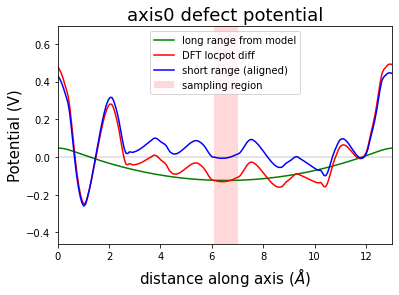

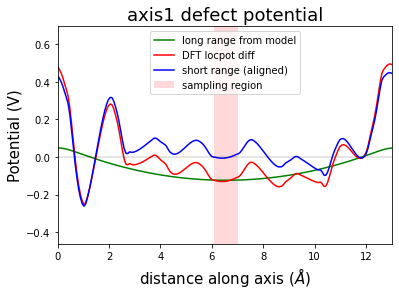

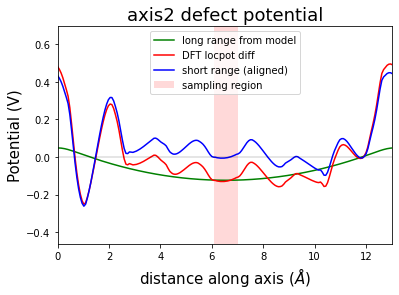

In [19]:
get_correction_freysoldt(vac_1_Cd_vgam_dict["-1_C3v"], dielectric, plot = True);

Final Freysoldt correction is 0.247 eV


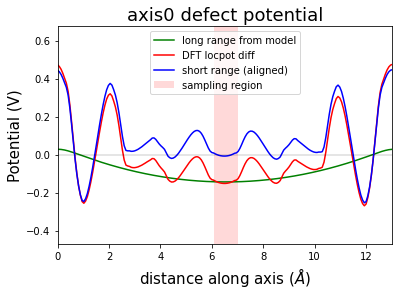

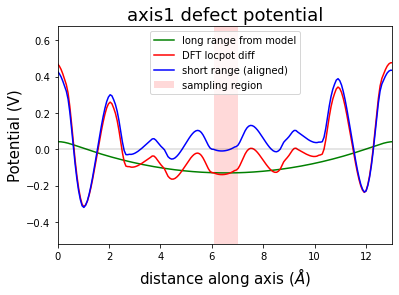

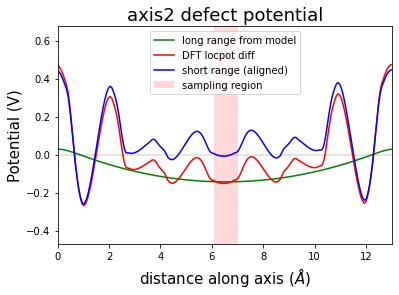

In [20]:
get_correction_freysoldt(vac_1_Cd_vgam_dict["-1_Td"], dielectric, plot = True);

Can save python objects using `dope_stuff.save_to_pickle`, then reload them later with `dope_stuff.load_from_pickle`, so we can restart the Python kernel and not have to re-parse everything.

In [2]:
cdte_chempots = dope_stuff.load_from_pickle('Pickled_stuff/cdte_chempot_limits.pickle')

In [3]:
parsed_vac_Cd_dict = dope_stuff.load_from_pickle('Pickled_stuff/parsed_vac_Cd_dict.pickle')

In [4]:
vac_Cd_dpd = dope_stuff.load_from_pickle('vac_Cd_dpd.pickle')

In [8]:
parsed_CdTe_defects_dict = dope_stuff.load_from_pickle('Pickled_stuff/parsed_CdTe_defects_dict.pickle')

In [9]:
parsed_CdTe_defects_dict.update(parsed_vac_Cd_dict)

In [10]:
dope_stuff.save_to_pickle(parsed_CdTe_defects_dict, 'Pickled_stuff/parsed_CdTe_defects_dict.pickle')

## The Main Event: Transition Level Diagrams

In [1]:
from doped import dope_stuff

In [2]:
vac_Cd_defects_dict = dope_stuff.load_from_pickle("Pickled_stuff/parsed_vac_Cd_dict.pickle") # Freysoldt corrected defects

# generate DefectPhaseDiagram object so we can plot/tabulate formation energies, calculate charge transition levels etc:
vac_Cd_dpd = dope_stuff.dpd_from_parsed_defect_dict(vac_Cd_defects_dict)

In [4]:
def_entry = vac_Cd_defects_dict["vac_1_Cd_-2"]

In [9]:
def_entry.defect.as_dict()["@class"]

'Vacancy'

In [2]:
vac_Cd_defects_dict = dope_stuff.load_from_pickle("Pickled_stuff/parsed_vac_Cd_dict.pickle") # Freysoldt corrected defects

# generate DefectPhaseDiagram object so we can plot/tabulate formation energies, calculate charge transition levels etc:
vac_Cd_dpd = dope_stuff.dpd_from_parsed_defect_dict(vac_Cd_defects_dict)

In [3]:
lz_corrected_vac_Cd_dict = dope_stuff.lany_zunger_corrected_defect_dict_from_freysoldt(vac_Cd_defects_dict)
# If you want to convert from the Freysoldt correction to the Lany-Zunger correction

In [4]:
lz_corrected_vac_Cd_dpd = dope_stuff.dpd_from_parsed_defect_dict(lz_corrected_vac_Cd_dict) 
# generate DefectPhaseDiagram object so we can plot/tabulate formation energies, calculate charge transition levels etc.

Here, I have already parsed my chemical potential calculations with `doped` (see the `doped_chempot_parsing_example` notebook), and saved it to a pickle file with `dope_stuff.save_to_pickle`, so that I can reload it in a new notebook (or new session with the same notebook), as below:

In [5]:
cdte_chempots = dope_stuff.load_from_pickle("Pickled_stuff/cdte_chempot_limits.pickle")

In [6]:
print(cdte_chempots)

{'facets': {'Cd-CdTe': {Element Cd: -1.01586484, Element Te: -5.7220097228125}, 'CdTe-Te': {Element Cd: -2.2671822228125, Element Te: -4.47069234}}, 'elemental_refs': {Element Te: -4.47069234, Element Cd: -1.01586484}, 'facets_wrt_elt_refs': {'Cd-CdTe': {Element Cd: 0.0, Element Te: -1.2513173828125002}, 'CdTe-Te': {Element Cd: -1.2513173828125, Element Te: 0.0}}}


Some of the advantages of parsing / manipulating your chemical potential calculations this way, is that:

- You can quickly loop through different points in chemical potential space (i.e. phase diagram facets), rather than typing out the chemical potentials obtained from a different method (e.g. from `CPLAP`).
- `doped` automatically determines the chemical potentials with respect to elemental references (i.e. chemical potentials are zero in their standard states (by definition), rather than VASP/DFT energies). This is the `facets_wrt_elt_refs` entry in the `cdte_chempots` dict in the cell above. 
- `doped` can then optionally print the corresponding phase diagram facet / chemical potential limit and the _formal_ chemical potentials of the elements at that point, above the formation energy plot, as shown in the next cell.

Alternatively, you can directly feed in pre-calculated chemical potentials to `doped`, see below for this.

Basic formation energy plot:

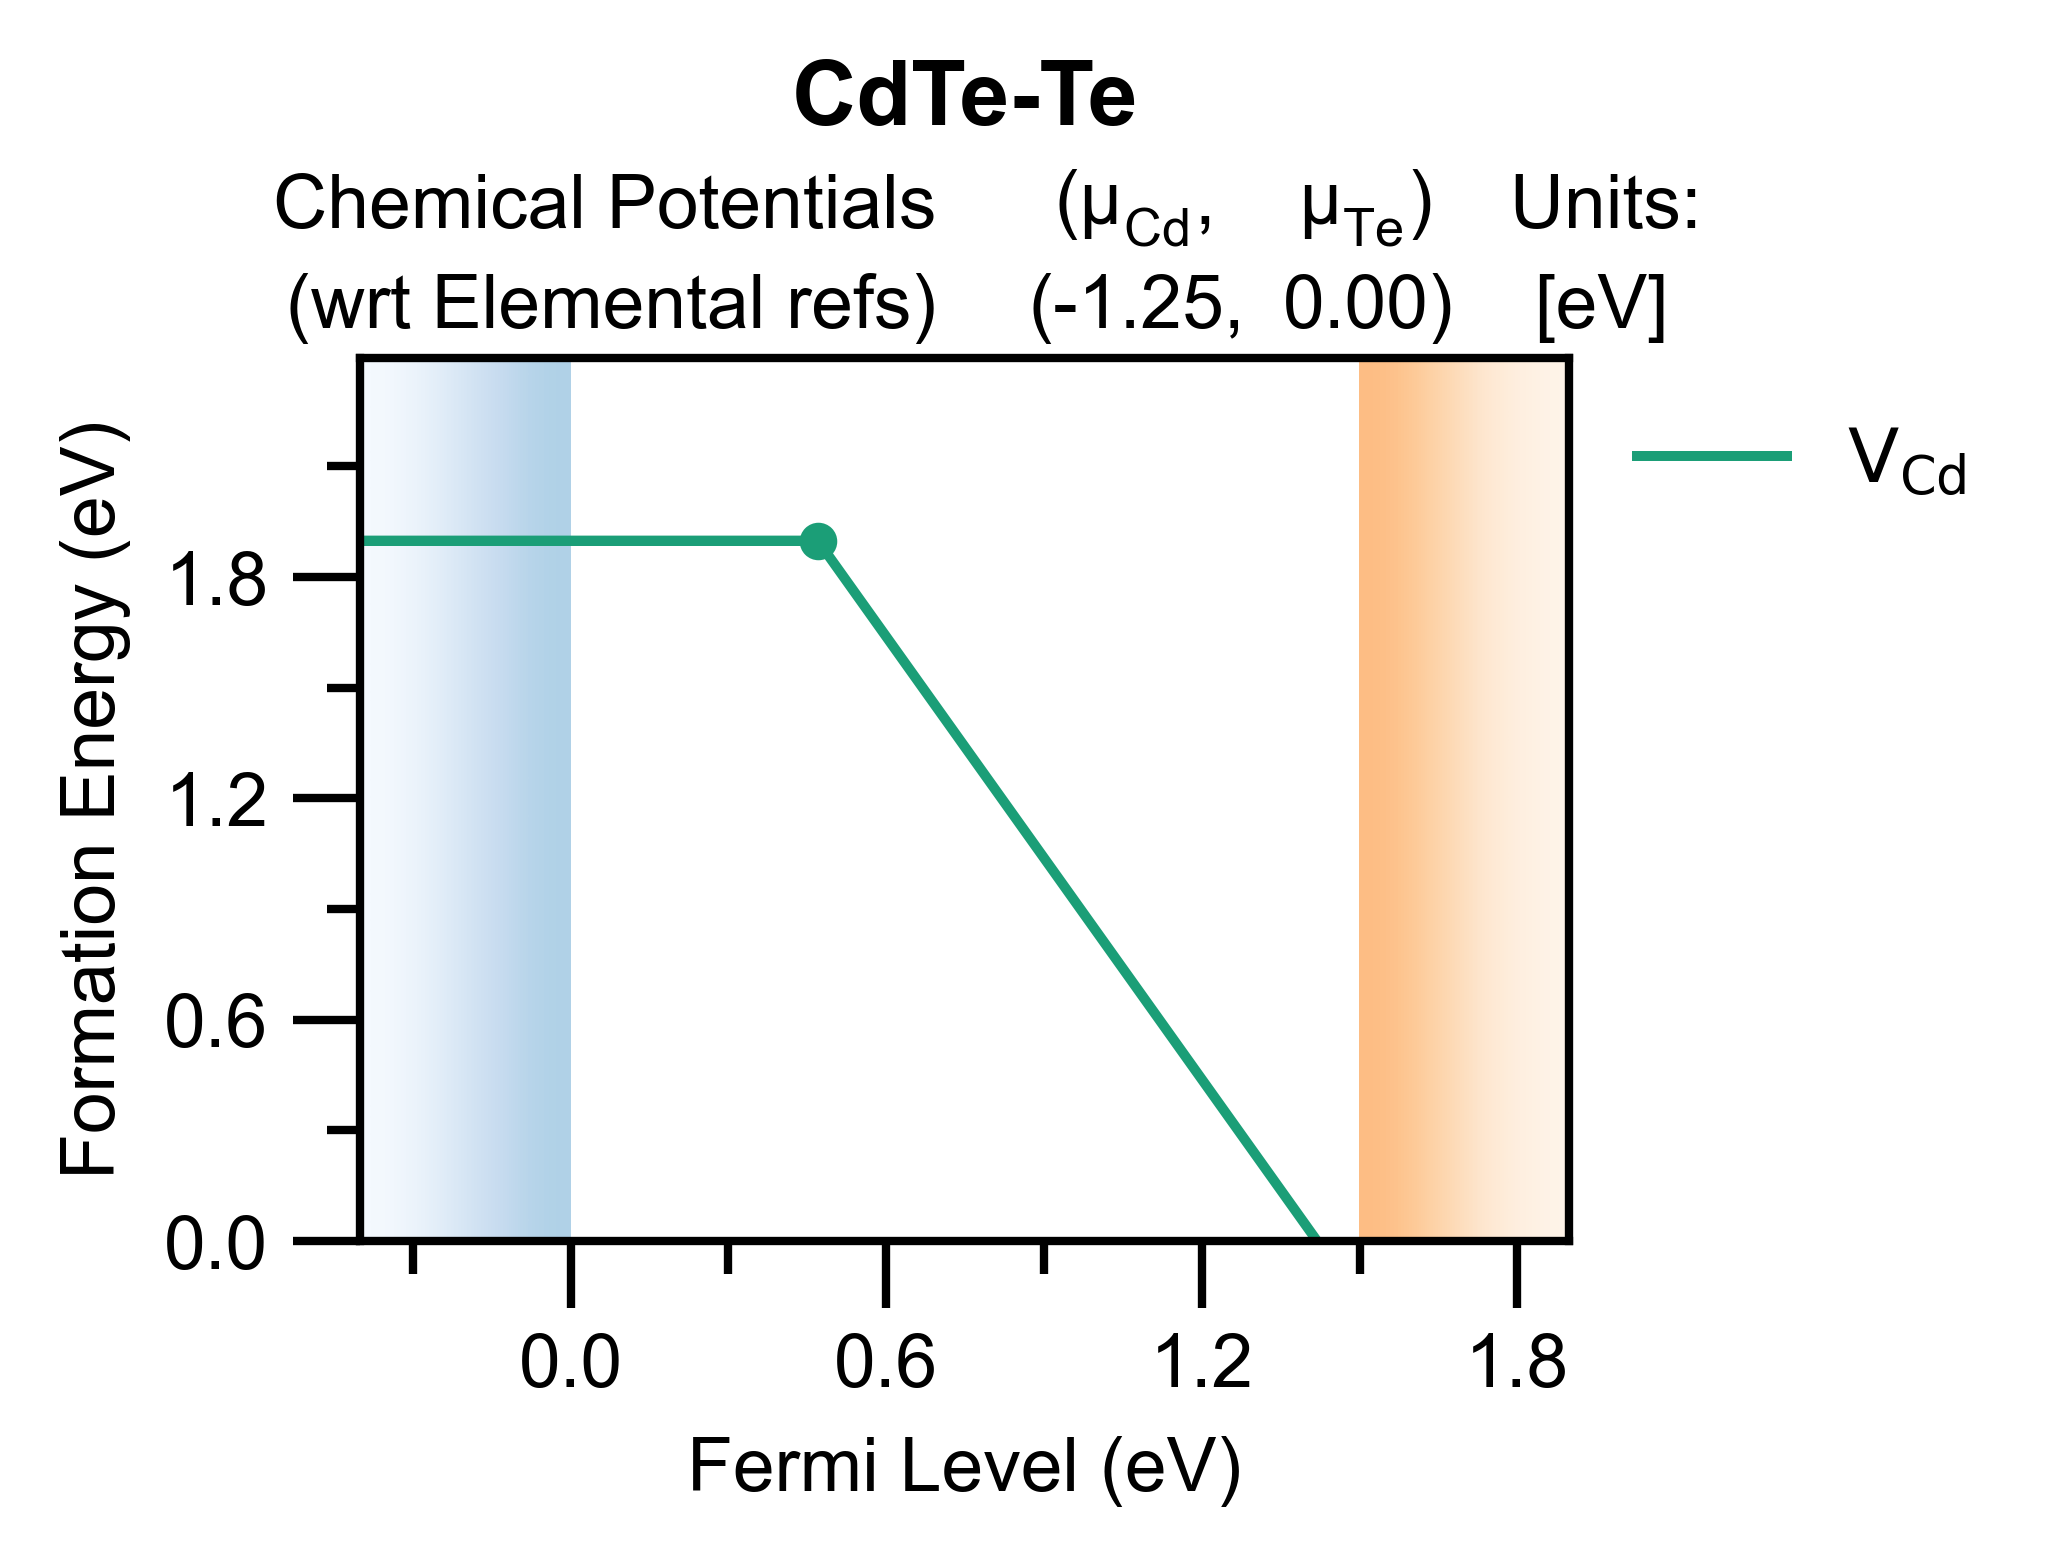

In [7]:
def_plot = dope_stuff.formation_energy_plot(
    vac_Cd_dpd,
    cdte_chempots,
    pd_facets=["CdTe-Te"],
)

There are a lot of options for making the formation energy plot prettier:

In [8]:
dope_stuff.formation_energy_plot?

Signature:
dope_stuff.formation_energy_plot(
    defect_phase_diagram,
    chempot_limits=None,
    ax=None,
    fonts=None,
    xlim=None,
    ylim=None,
    ax_fontsize=1.0,
    lg_fontsize=1.0,
    lg_position=None,
    fermi_level=None,
    title: str = None,
    saved=False,
    colormap='Dark2',
    minus_symbol='-',
    frameon=False,
    chem_pot_table=True,
    pd_facets: list = None,
    auto_labels: bool = False,
    filename: str = None,
    emphasis=False,
)
Docstring: <no docstring>
File:      ~/OneDrive - Imperial College London/Bread/Projects/Packages/doped/doped/dope_stuff.py
Type:      function


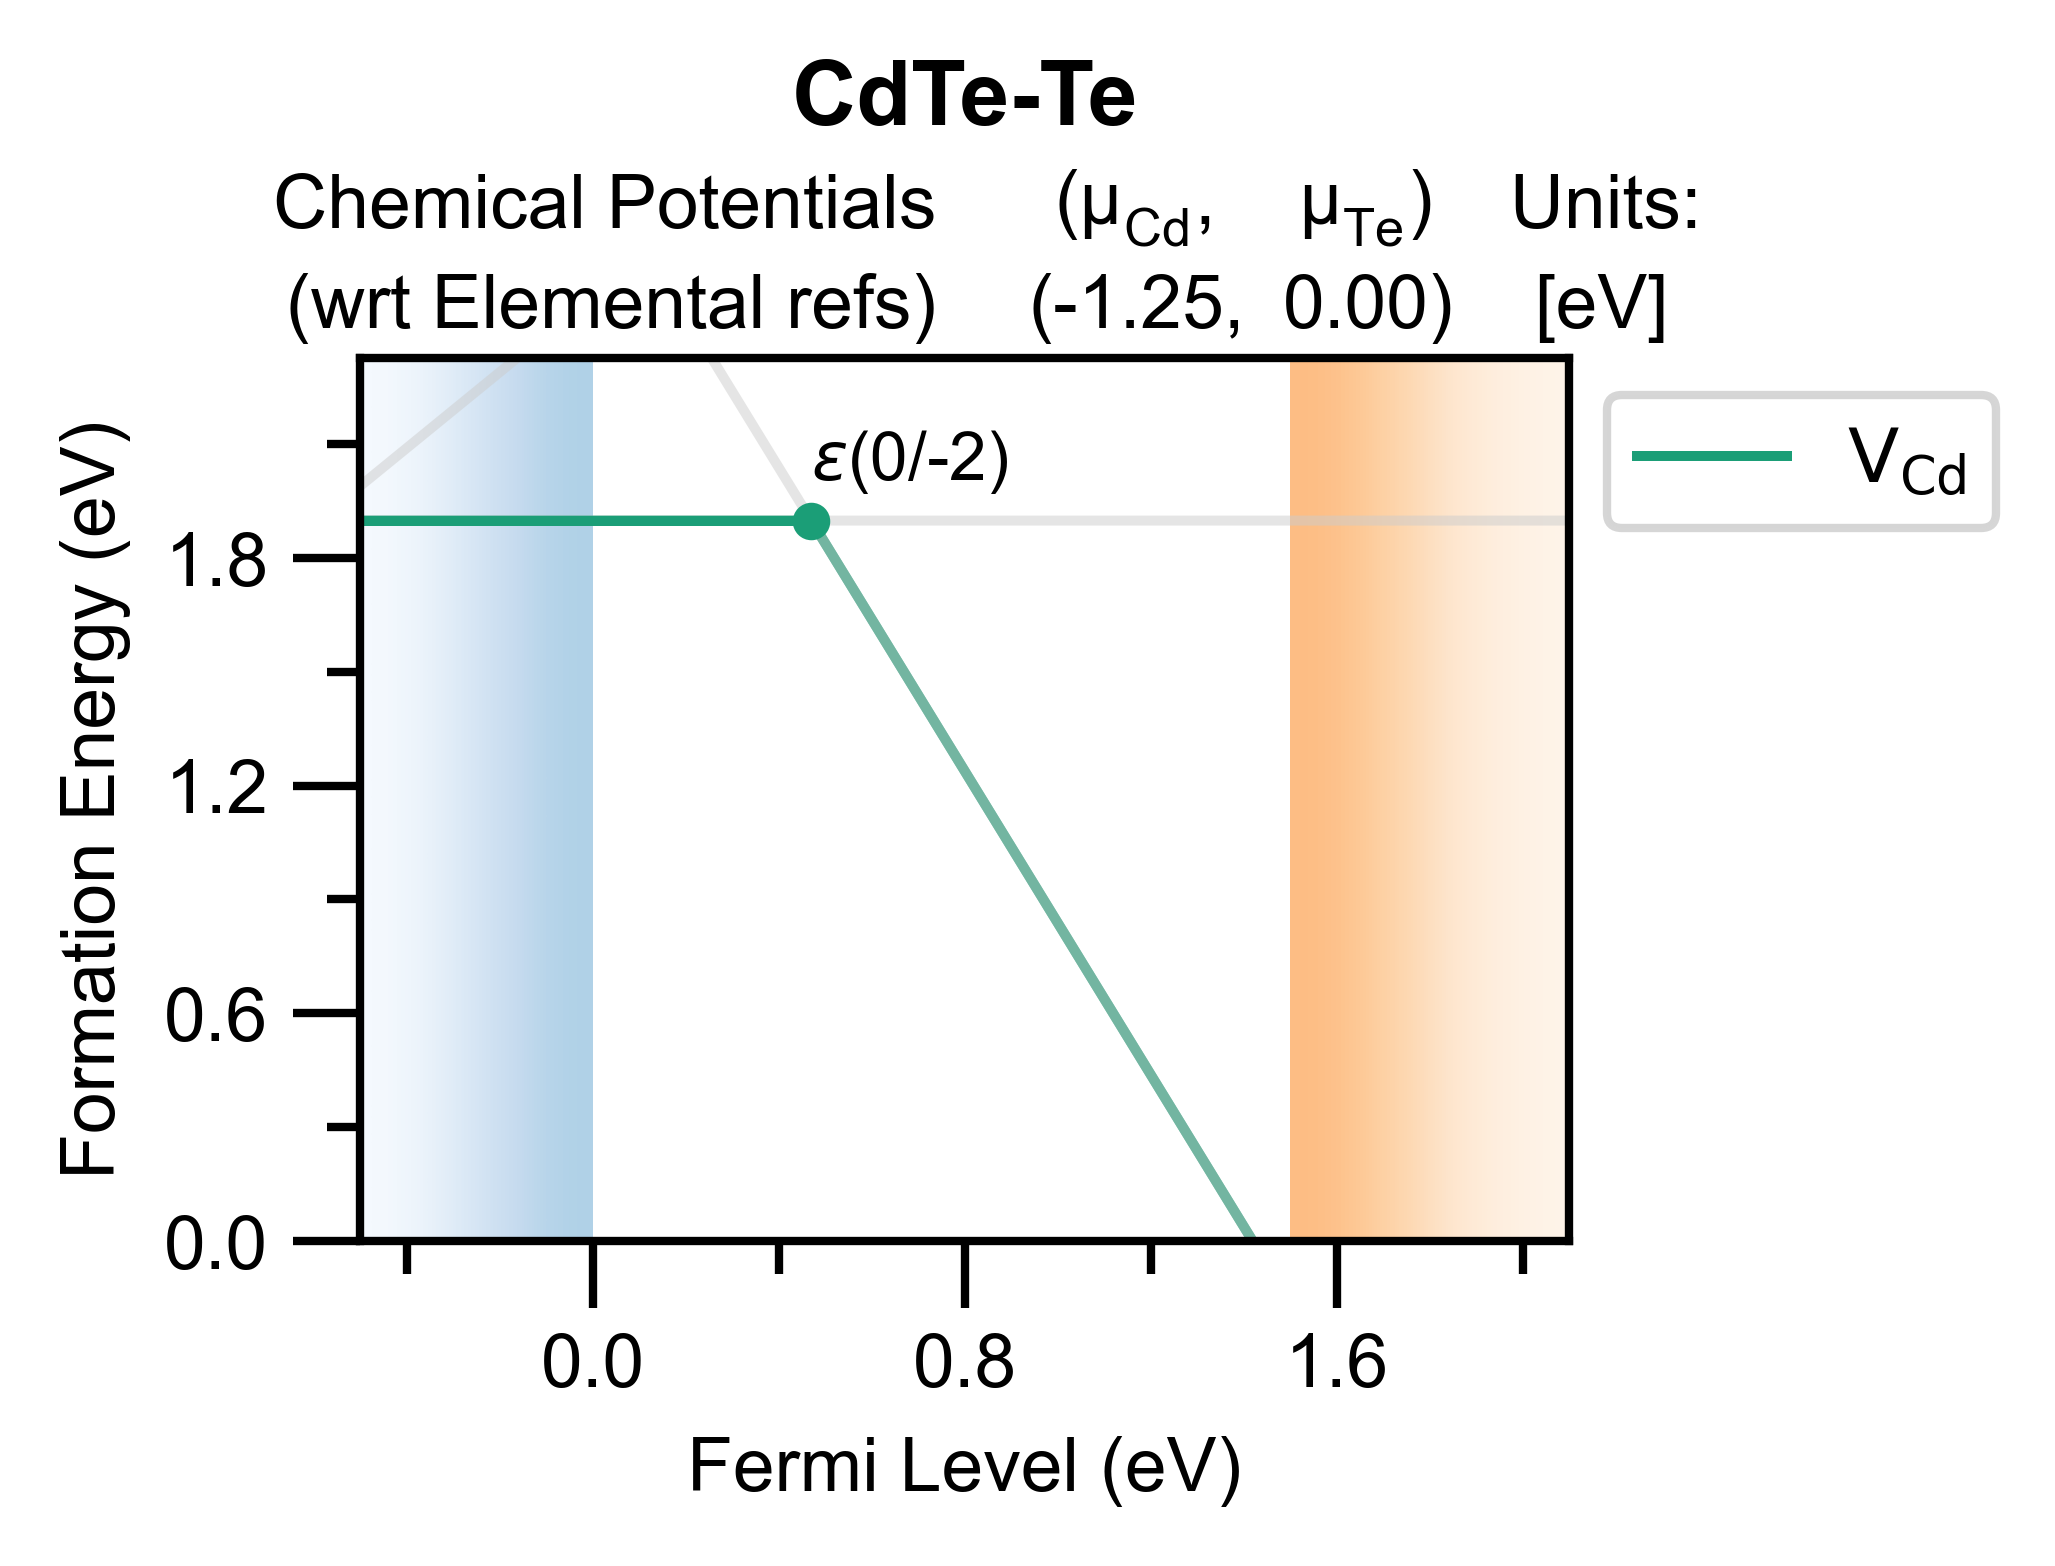

In [10]:
def_plot = dope_stuff.formation_energy_plot(
    vac_Cd_dpd,
    cdte_chempots,
    auto_labels=True,
    xlim=(-0.5, 2.1),
    emphasis=True,
    frameon=True,
    pd_facets=["CdTe-Te"],
    saved=True, # Save plot and give filename
    filename="V_Cd_Formation_Energy_Te-Rich.pdf"
)

`dope_stuff.formation_energy_plot` also returns the `matplotlib` plot object, so you can customise this as much as you like!

**Manually inputting chemical potentials:**

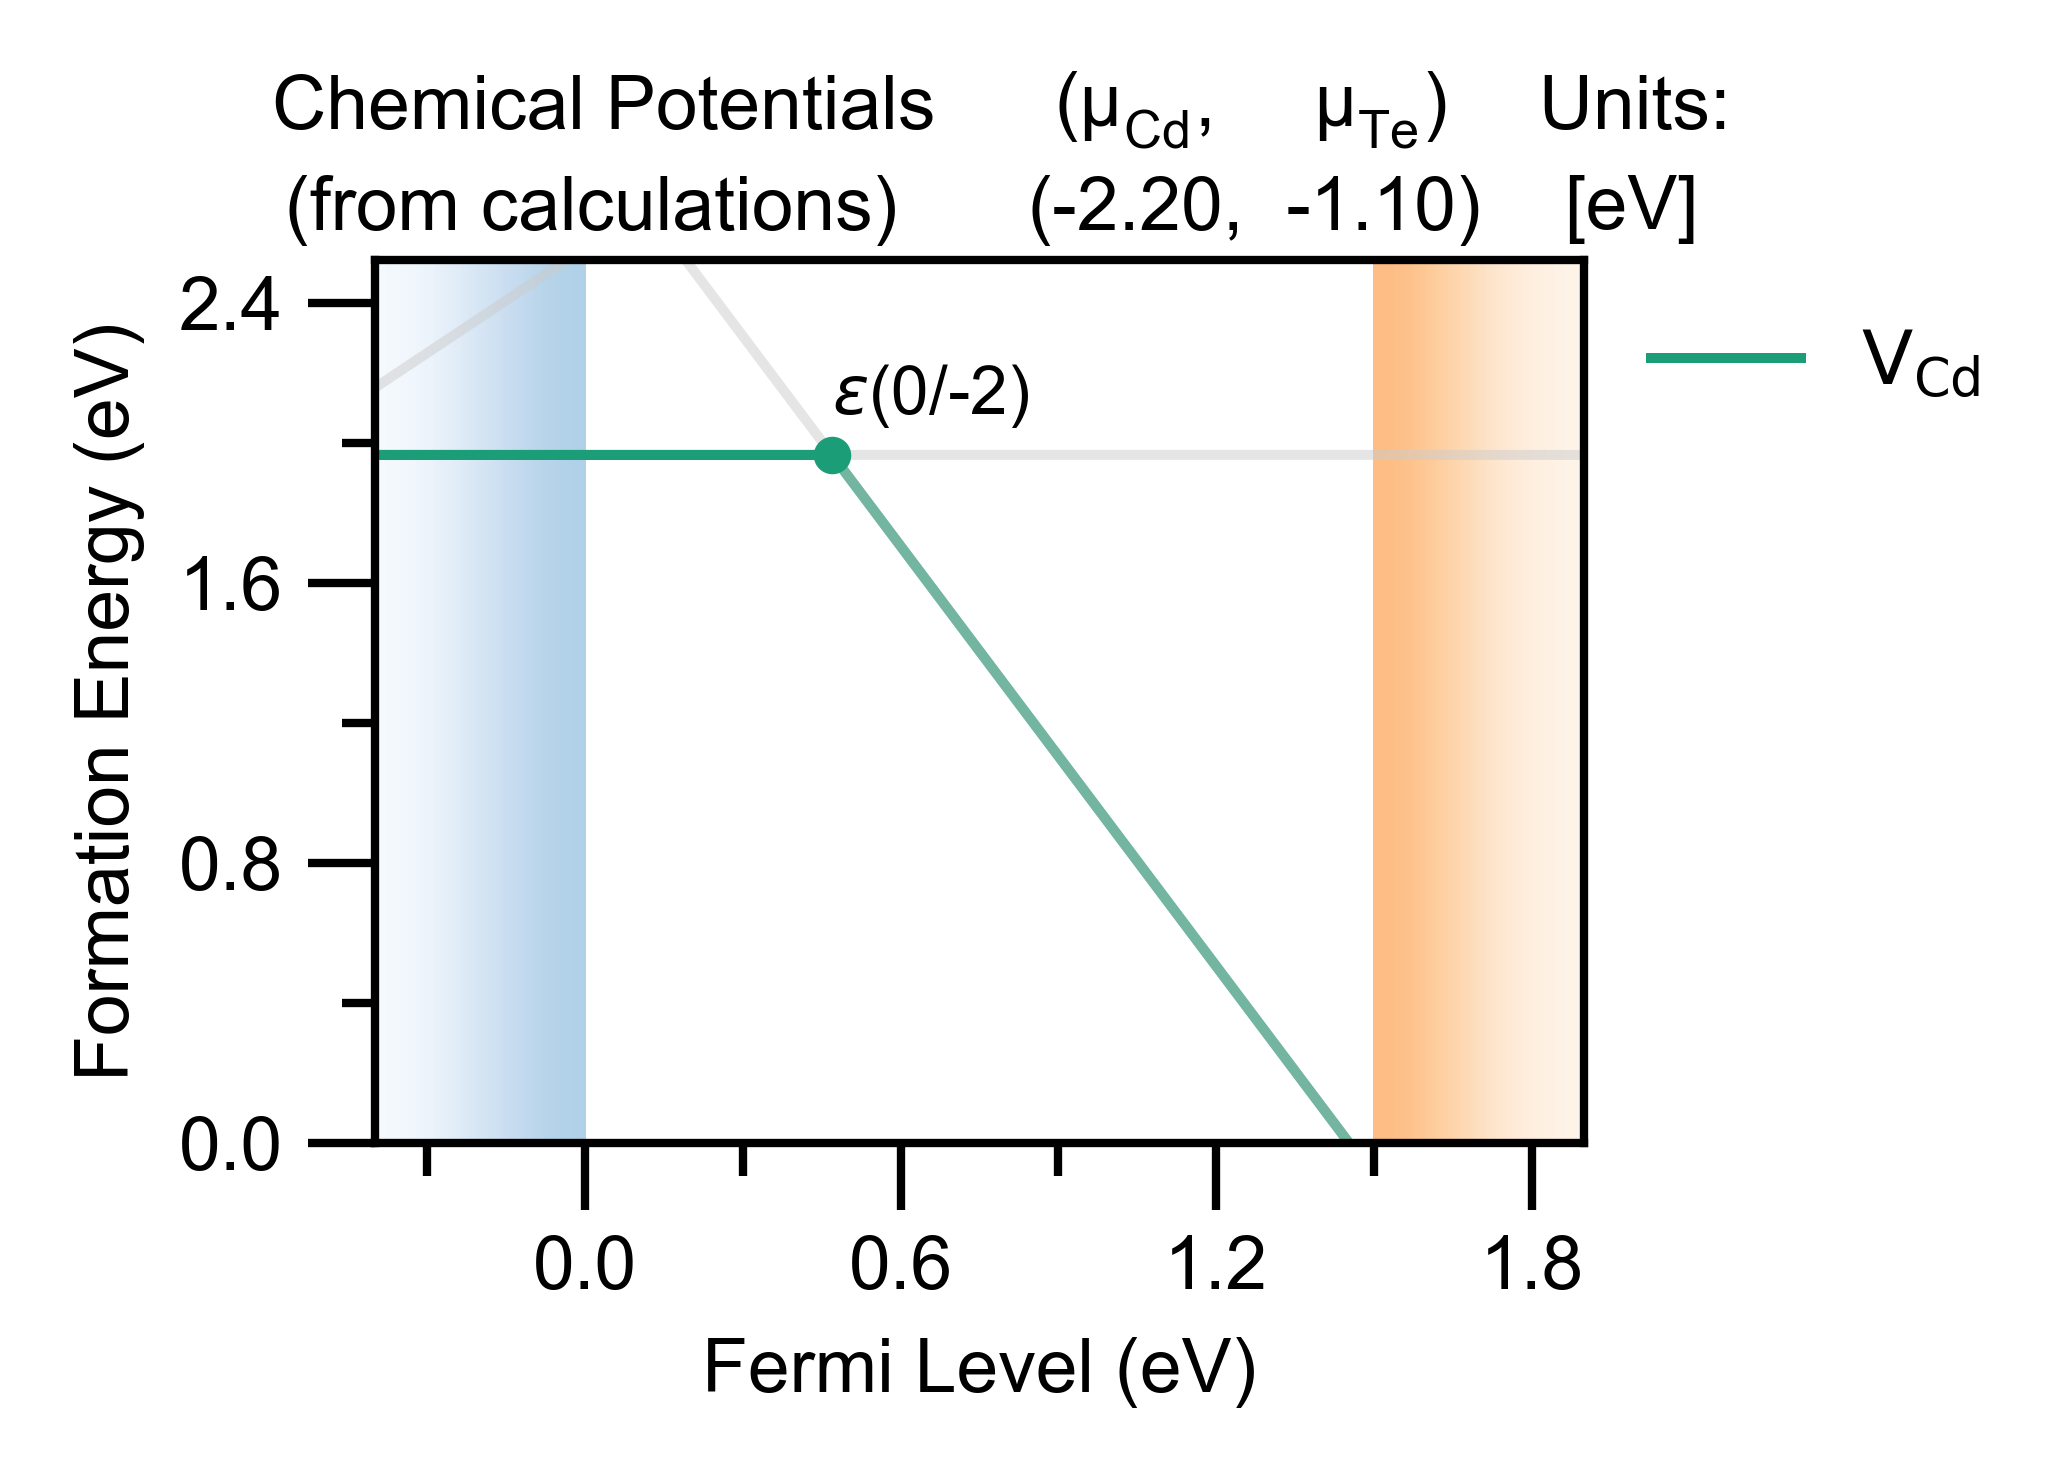

In [11]:
def_plot = dope_stuff.formation_energy_plot(
    vac_Cd_dpd,
    chempot_limits = {"Cd": -2.2, "Te": -1.1},
    auto_labels=True,
    emphasis=True,
)

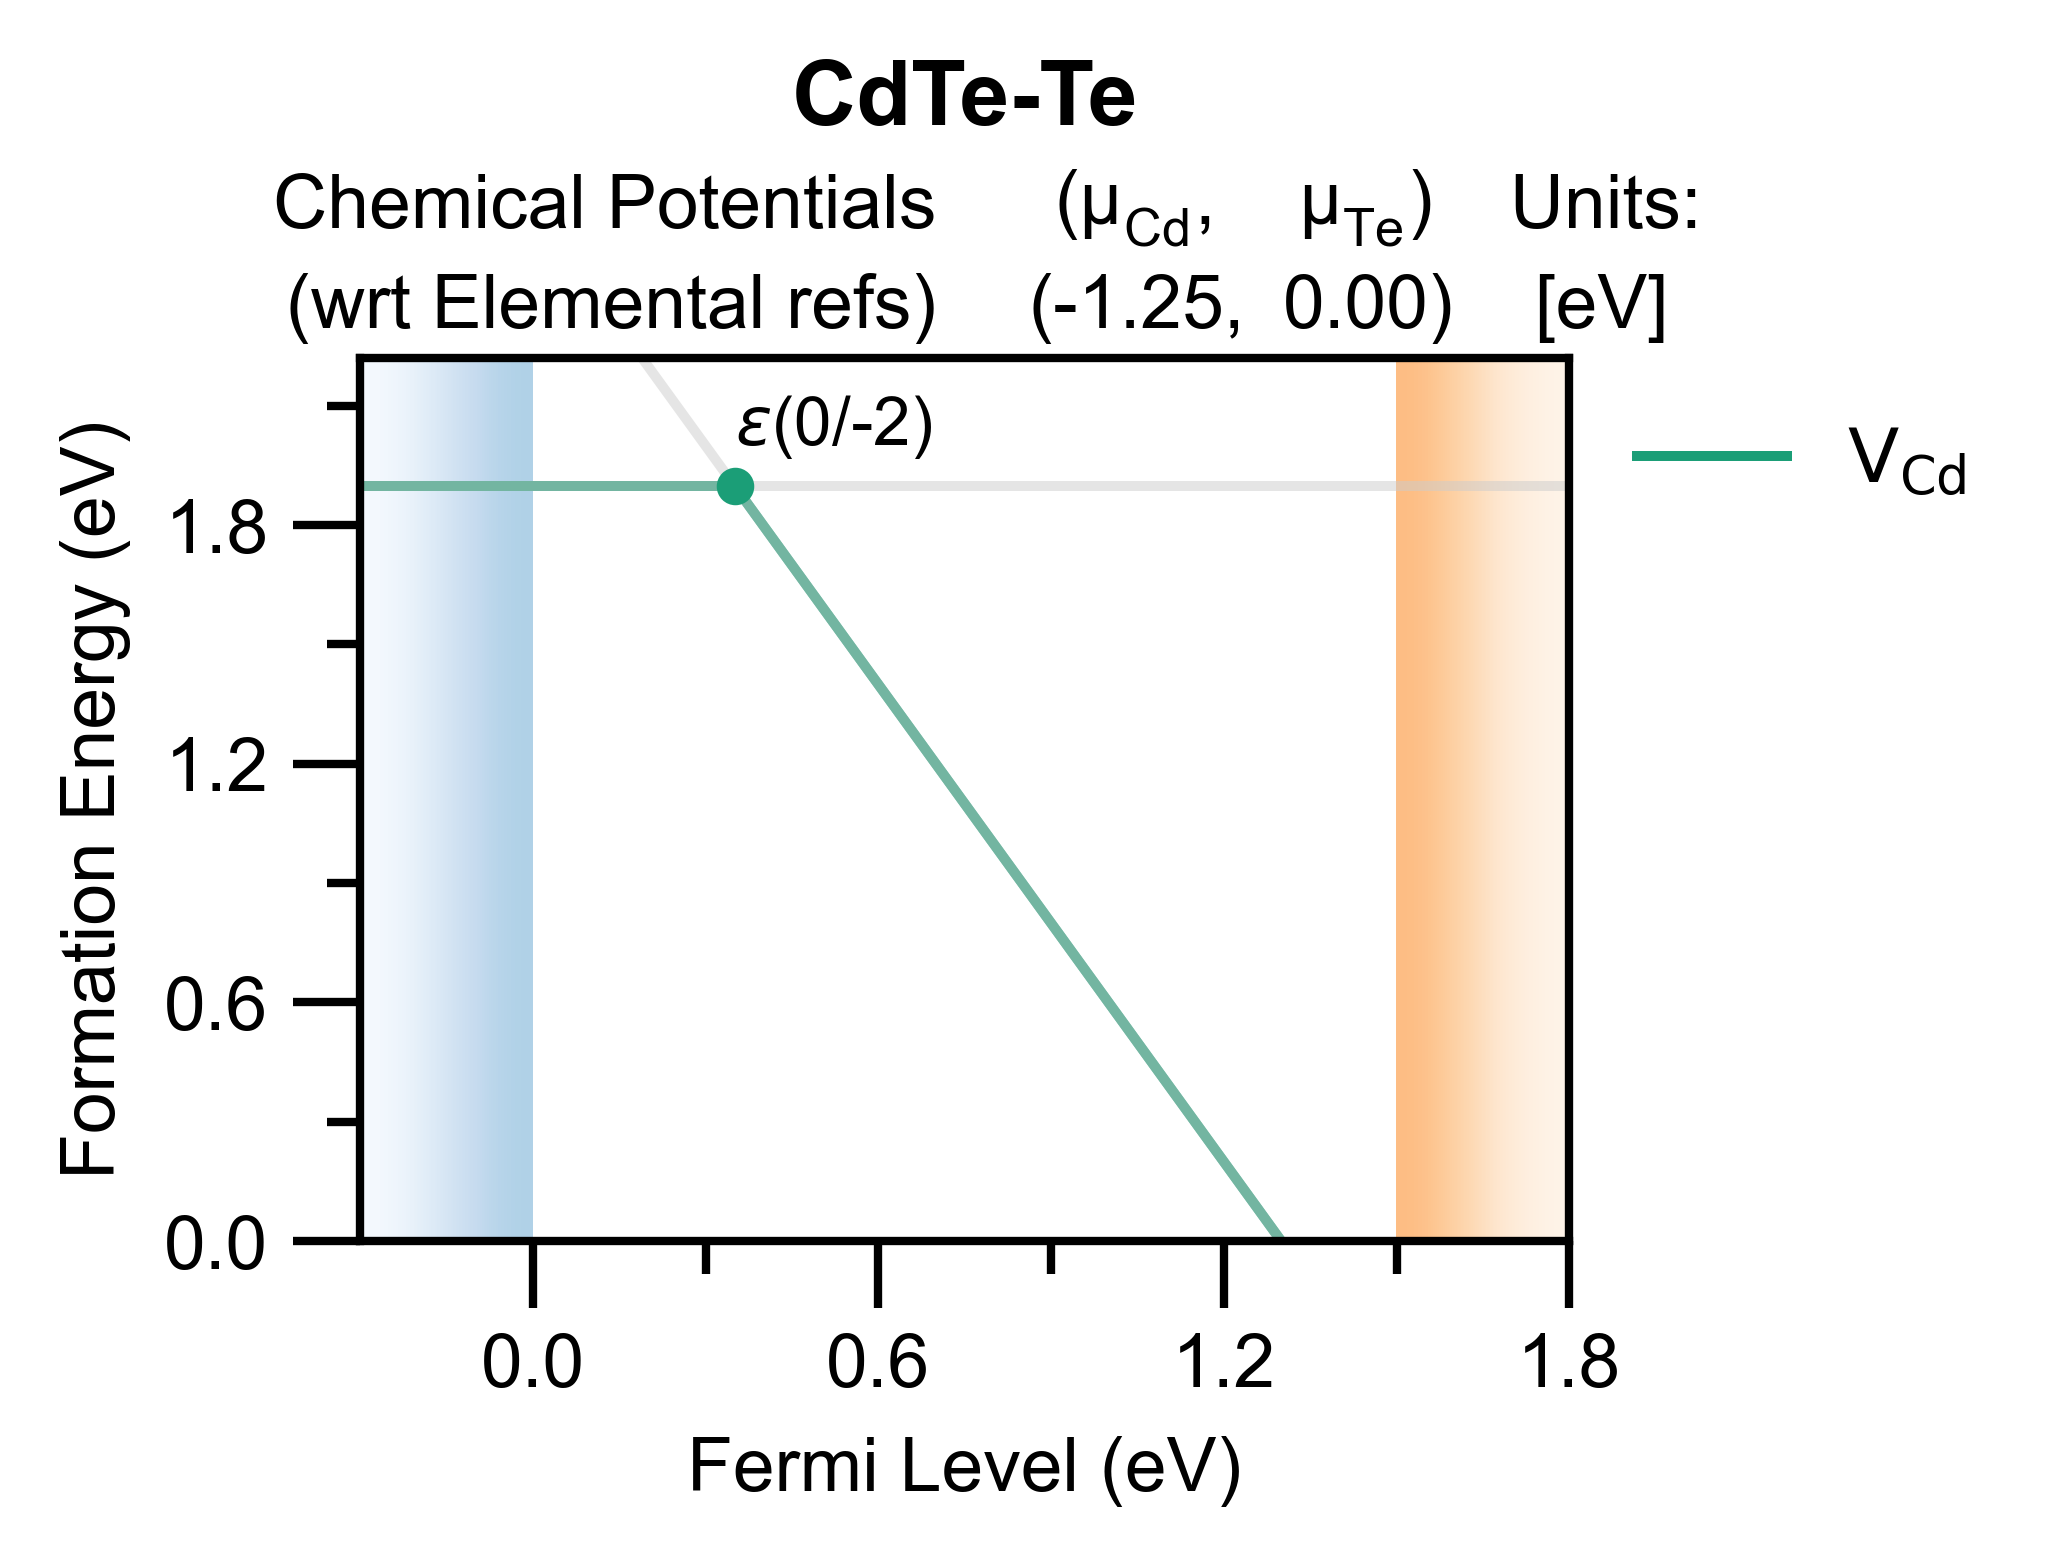

In [40]:
lzdef_plot = dope_stuff.formation_energy_plot(
    adjusted_lz_vac_Cd_dpd,
    cdte_chempots,
    auto_labels=True,
    xlim=(-0.3, 1.8),
    emphasis=True,
    pd_facets=["CdTe-Te"],
    filename="V_Cd_LZ_Te-Rich.pdf"
)

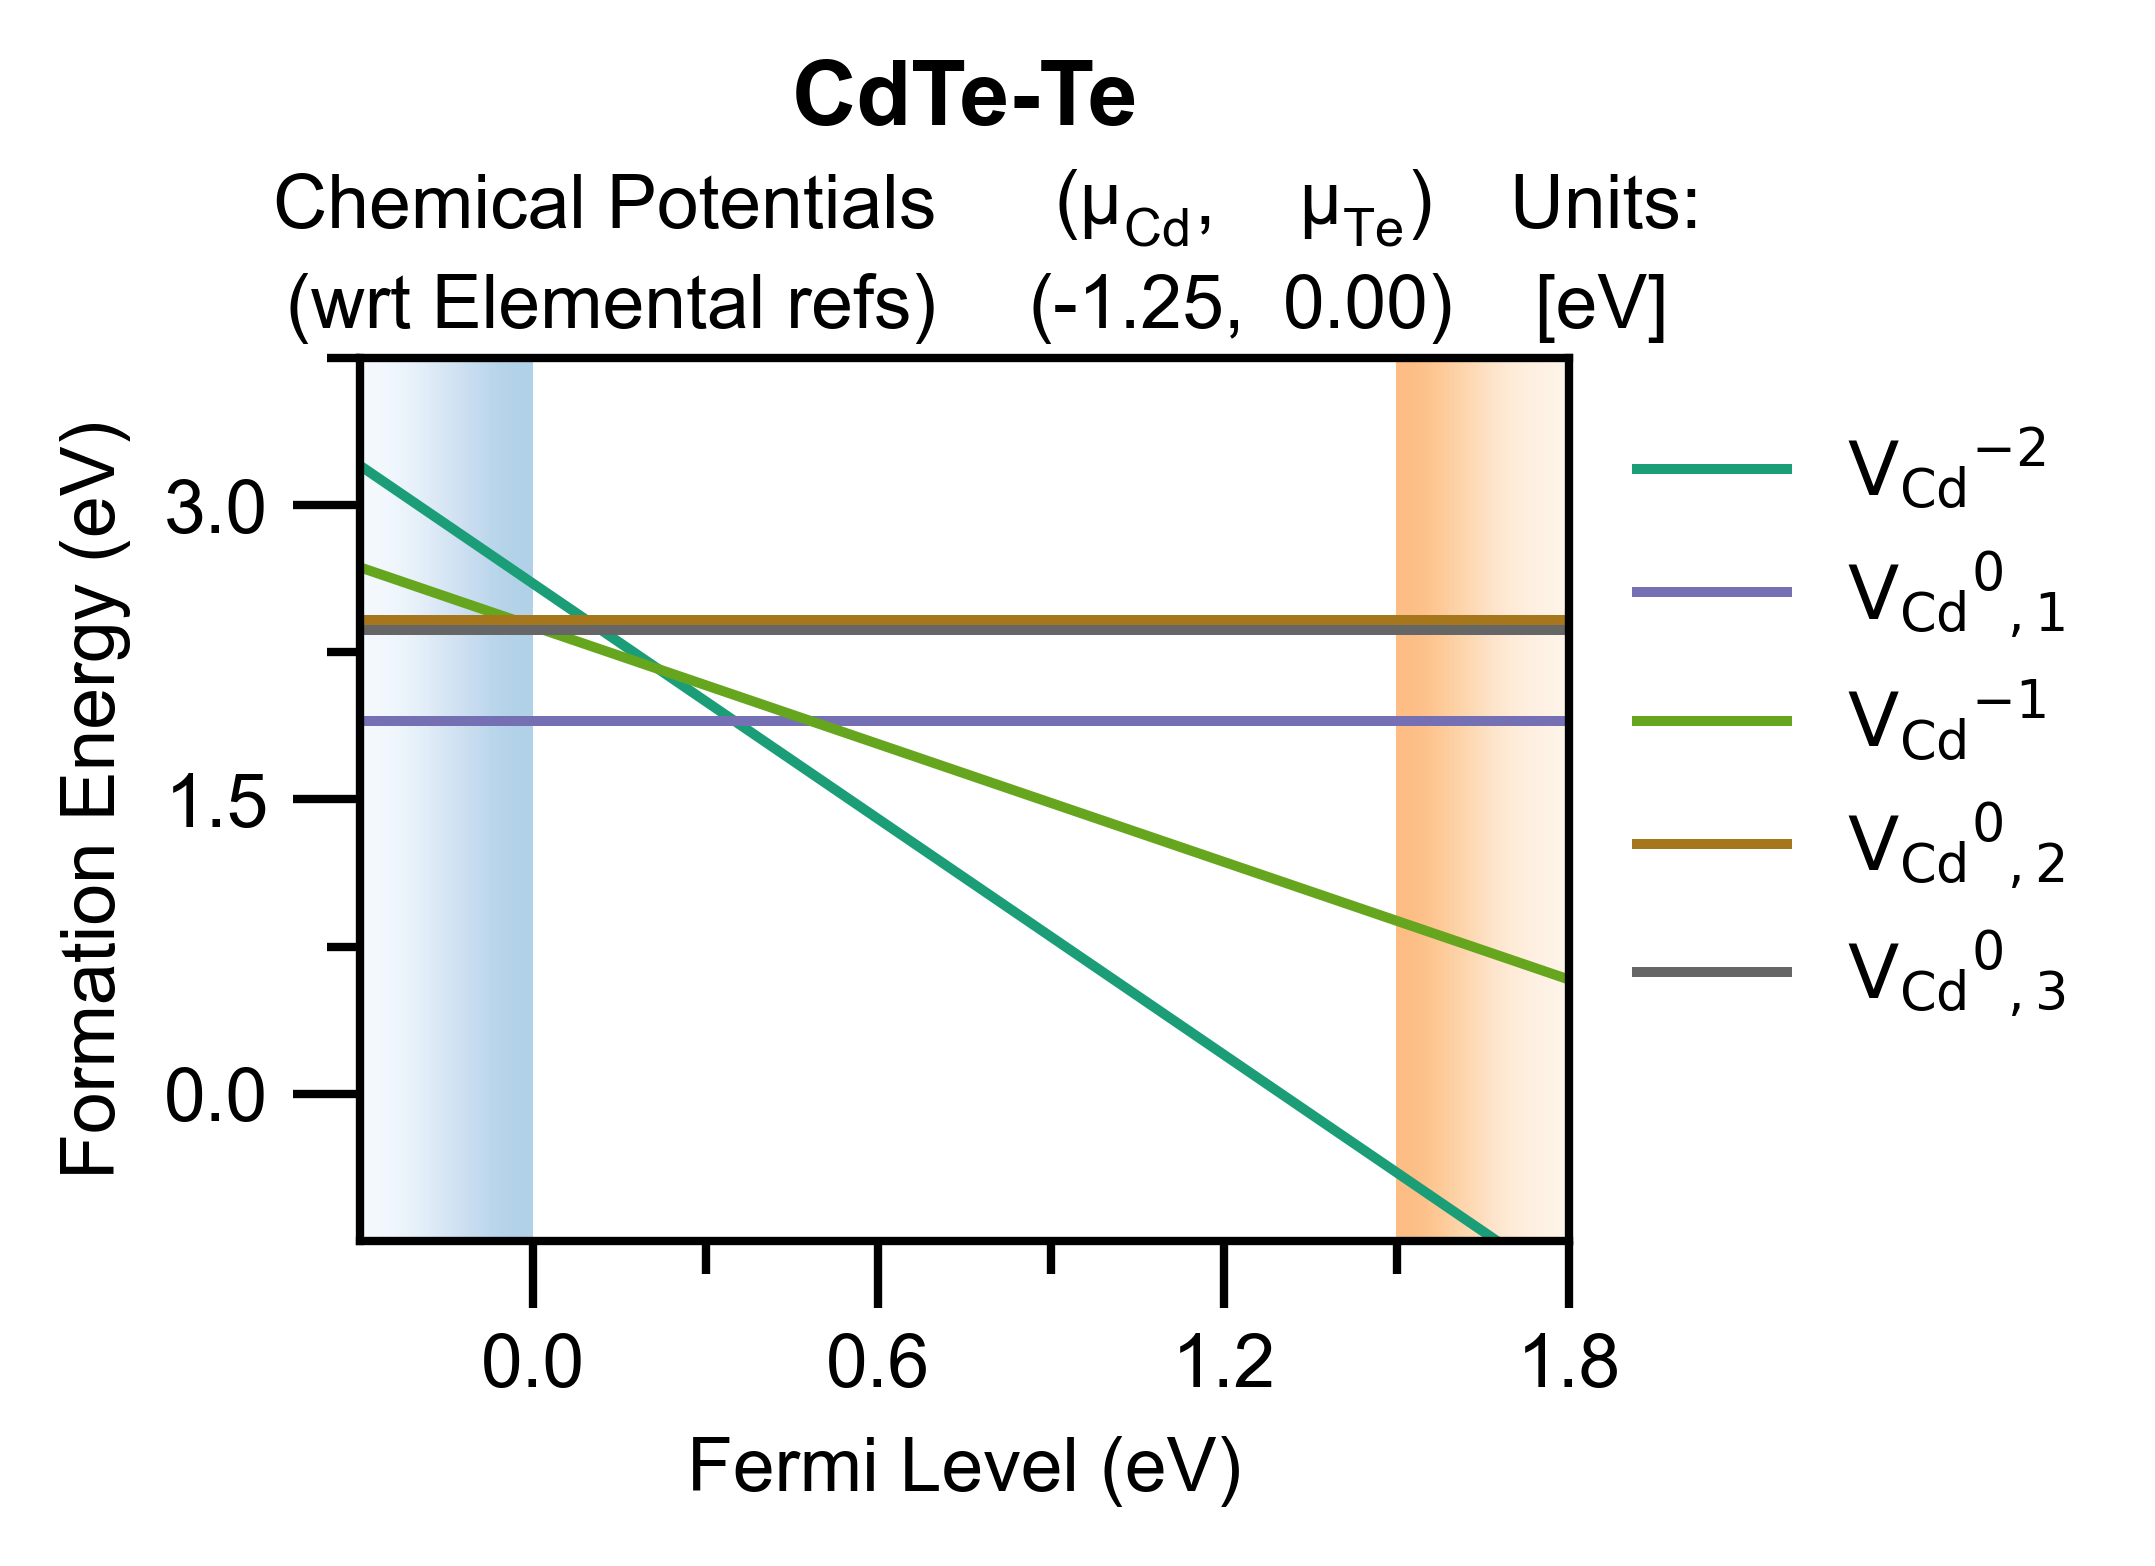

In [42]:
def_plot = dope_stuff.all_lines_formation_energy_plot(
    adjusted_lz_vac_Cd_dpd,
    cdte_chempots,
    auto_labels=False,
    xlim=(-0.3, 1.8),
    ylim=(-0.75,3.75),
    pd_facets=["CdTe-Te"],
    filename="V_Cd_LZ_Te-Rich_All_Lines.pdf"
)

# $V_{Cd}^{0}$ Concentrations

In [66]:
lz_Cd_defects_dpd = dope_stuff.load_from_pickle("Pickled_stuff/lz_CdTe_defects_dpd.pickle")

In [67]:
cdte_chempots = dope_stuff.load_from_pickle("Pickled_stuff/cdte_chempot_limits.pickle")

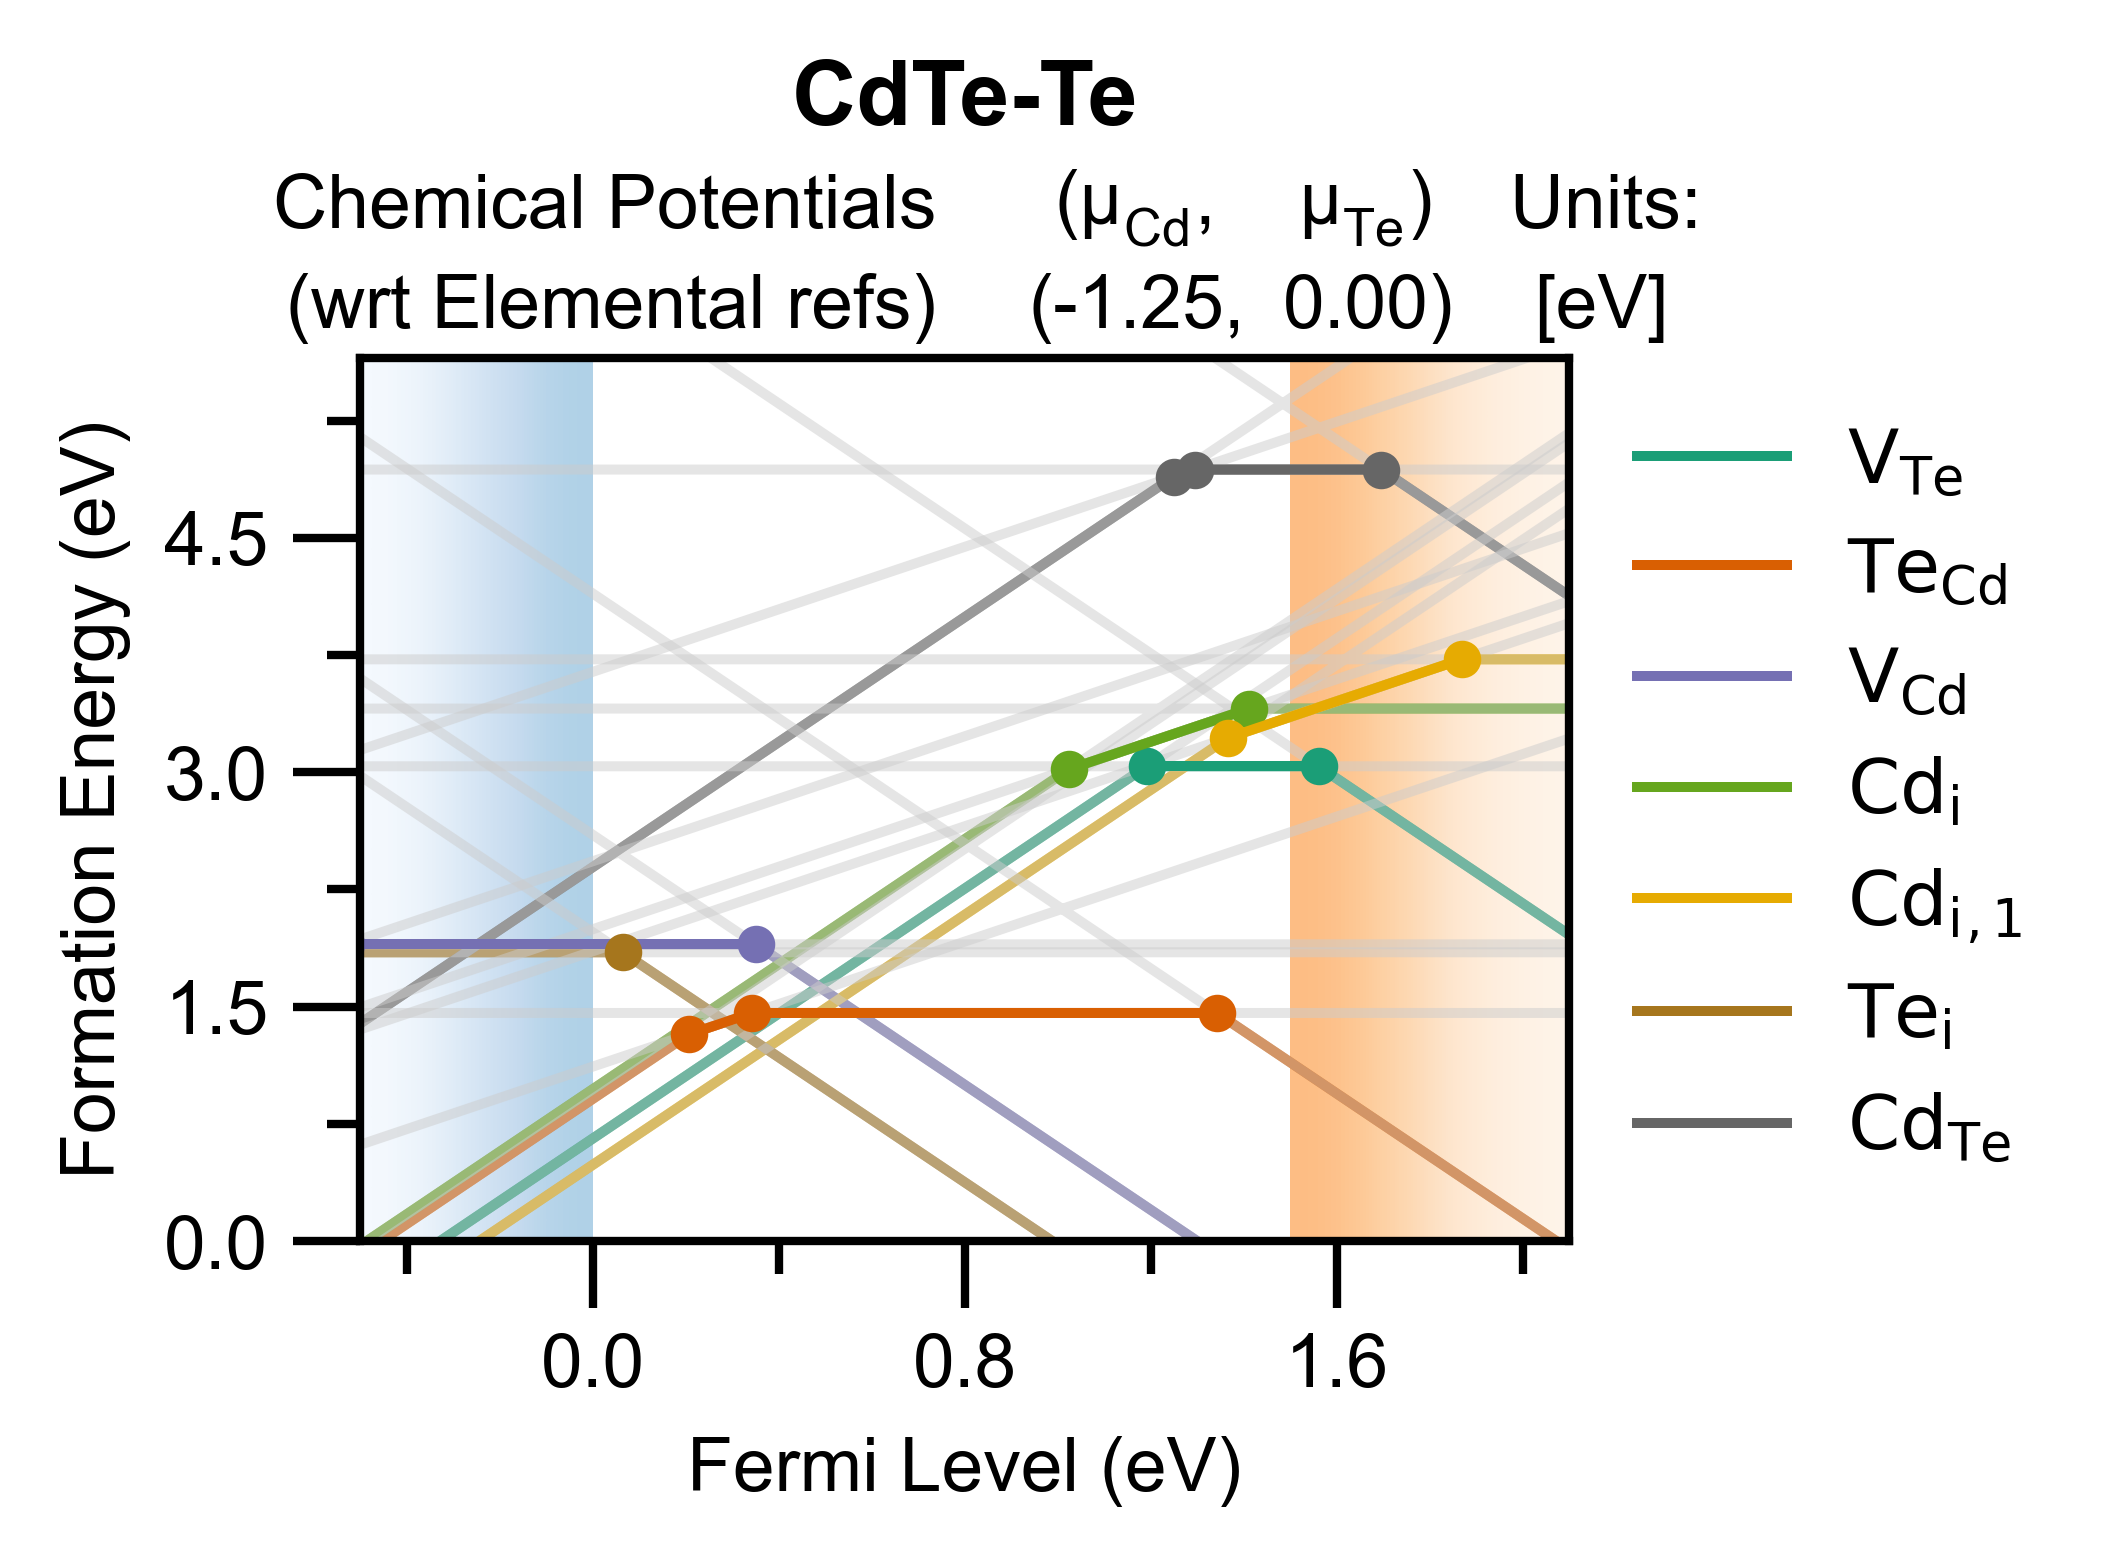

In [21]:
def_plot = dope_stuff.formation_energy_plot(
    lz_Cd_defects_dpd,
    cdte_chempots,
    #auto_labels=True,
    xlim=(-0.5, 2.1),
    emphasis=True,
    pd_facets=["CdTe-Te"],
)

In [76]:
[defect.energy for defect in lz_Cd_defects_dpd.entries if defect.name == "Vac_Cd_mult32"]

[8.159487929384449,
 4.165717260000008,
 6.295109020833332,
 3.050583859310708,
 4.682410190000013]

In [77]:
vac_Cd_0_sorted = sorted([defect for defect in lz_Cd_defects_dpd.entries if defect.name == "Vac_Cd_mult32" and defect.charge == 0], key=lambda x: x.energy)
vac_Cd_0_Te_dimer = vac_Cd_0_sorted[0]

In [78]:
def_energy = lambda x: x.energy
def_energy(vac_Cd_0_sorted[0])

4.165717260000008

In [47]:
print(f"V_Cd^0 concentration in p-type CdTe at T=1000K: {vac_Cd_0_Te_dimer.defect_concentration(cdte_chempots['facets']['CdTe-Te'], temperature=1000, fermi_level = 0.3):.2E} cm^3")

V_Cd^0 concentration in p-type CdTe at T=1000K: 3.86E+12 cm^3


In [46]:
print(f"V_Cd^0 formation energy in p-type CdTe: {vac_Cd_0_Te_dimer.formation_energy(cdte_chempots['facets']['CdTe-Te'], fermi_level = 0.3):.3f} eV")

V_Cd^0 formation energy in p-type CdTe: 1.899 eV


In [70]:
from doped.pycdt.utils.parse_calculations import get_vasprun

In [71]:
CdTe_dos_vr = get_vasprun("prim_cell_DOS/vasprun.xml.gz")

In [75]:
T = 273.15 + 750 # 750 degrees C
lz_Cd_defects_dpd.solve_for_fermi_energy(T, cdte_chempots["facets"]["CdTe-Te"], CdTe_dos_vr.complete_dos)

0.5158090324034222

In [79]:
print(f"V_Cd^0 concentration in p-type CdTe at T=1000K: {vac_Cd_0_Te_dimer.defect_concentration(cdte_chempots['facets']['CdTe-Te'], temperature=T, fermi_level = 0.5158):.2E} cm^3")

V_Cd^0 concentration in p-type CdTe at T=1000K: 6.35E+12 cm^3
